In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
import requests
import json
import scvi
from sklearn.cluster import KMeans

In [3]:
sys.path.append("/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/")

In [4]:
import RNAseq
importlib.reload(RNAseq)

<module 'RNAseq' from '/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/RNAseq.py'>

In [5]:
cell_line = "GRHL2"
project = "sc-MCF7+MDAMB231-pmig-GRHL2_DSP1090"

### Plotting parameters

In [6]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [8]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/raw_cb_frequency.txt", header=None)[1]

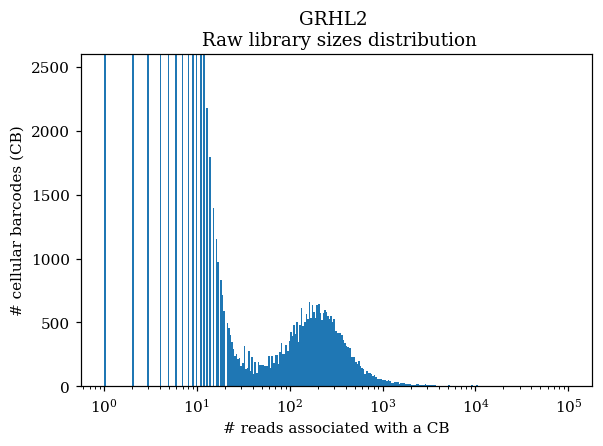

In [9]:
plt.title(f"{cell_line} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
RNAseq.plot_loghist(y, bins=300)

In [30]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/featureDump.txt")

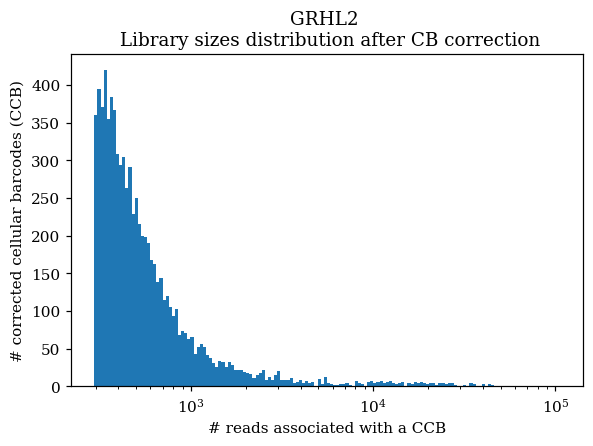

In [11]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["CorrectedReads"], bins=150)

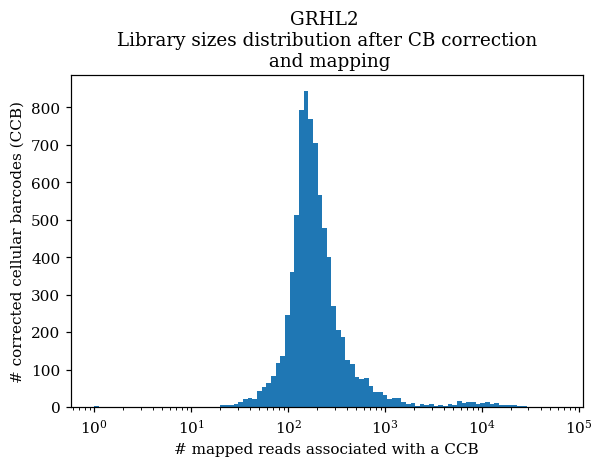

In [12]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["MappedReads"], bins=100)

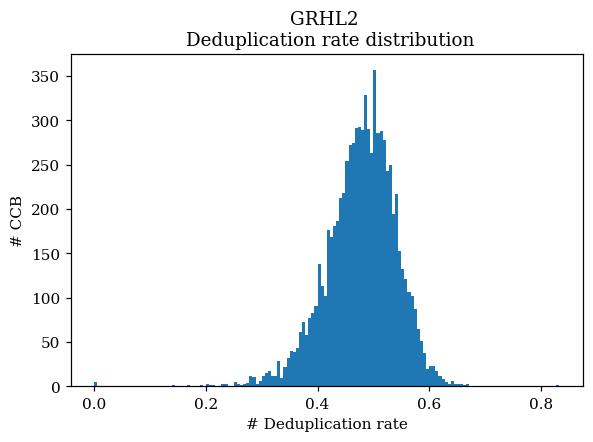

In [34]:
plt.title(f"{cell_line} \n Deduplication rate distribution")
plt.xlabel("# Deduplication rate")
plt.ylabel("# CCB")
plt.hist(x["DedupRate"], bins=150);

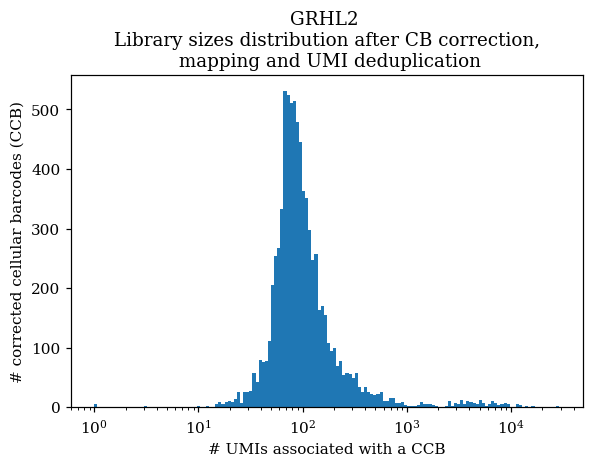

In [13]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["DeduplicatedReads"], bins=150)

### Loading raw count matrix

In [7]:
sc = RNAseq.sc_Dataset(project_path = f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}", samples_id = "condition", samples= [cell_line], quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "raw", cdna = "3' tag")
# sc.annotate_genes(annot_name = "external_gene_name")
# sc.annotate_genes(annot_name = "chromosome_name")
# sc.annotate_samples(annot_name= "mt_frac")
# sc.annotate_samples(annot_name= "rp_frac")
sc.save()

Annotating condition...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [8]:
sc.mtx.shape

(7925, 20305)

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/scvi/data/_anndata.py:795: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


INFO     Successfully registered anndata object containing 7925 cells, 20305 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
INFO     Training for 50 epochs                                                              


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


INFO     Training without KL warmup                                                          
Training...: 100%|██████████| 50/50 [02:12<00:00,  2.66s/it]
INFO     Training time:  85 s. / 50 epochs                                                   
         Train         Test
0   978.849765  1118.042373
1   710.862172   776.310749
2   650.428034   703.672503
3   613.371618   685.361375
4   610.849187   682.669240
5   633.416362   689.565662
6   609.007300   679.226231
7   608.260564   679.280101
8   607.823591   675.808014
9   602.265994   674.149029
10  601.315413   672.709717
11  597.970596   672.238141
12  597.556795   671.698460
13  597.561190   672.201983
14  596.544345   670.670710
15  595.384883   669.630842
16  594.901030   670.096525
17  593.954441   667.911160
18  594.032663   667.848366
19  593.717624   668.333193
20  592.566337   666.759601
21  592.752840   667.218312
22  591.906450   666.531403
23  591.646093   665.812778
24  591.277187   666.146739
25  590.429059   665.38

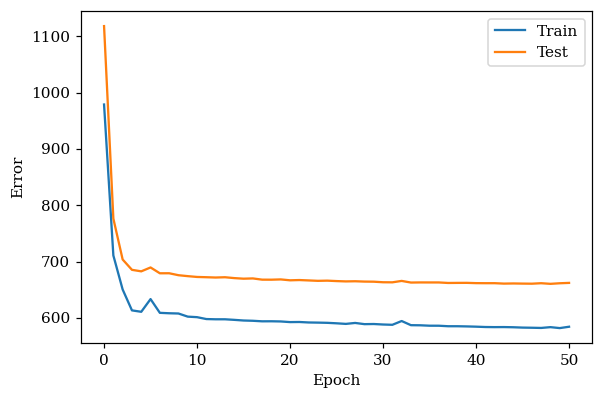

In [8]:
sc.reload()
sc.annotate_genes(genes_annot_name = "external_gene_name")

# sc.select_genes(genes_annot_name="ensembl_gene_id", genes_annot=vg)
# sc.annotate_samples(samples_annot_name="rp_frac")
adata_scvi = AnnData(sc.mtx, obs={"condition":sc.condition}, var={"var_names":sc.external_gene_name})
# scvi.data.poisson_gene_selection(adata_scvi,
#                                  #batch_key='batch', # estimate a dispersion parameter batchwise
#                                  n_top_genes = 1000, # how many genes to select
#                                  n_samples=30000
#                                  )
# adata_scvi = adata_scvi[:,adata_scvi.var['highly_variable']]
adata_scvi = adata_scvi.copy()
scvi.data.setup_anndata(adata_scvi) #batch_key="rp_frac") #, labels_key='cell_line') # batch_key = 'project' => not good : dsp762 contains only luminals, remove signal !

### DEFINE MODEL
model = scvi.model.SCVI(adata_scvi,  
                        n_hidden=128, 
                        n_layers=1,
                        n_latent=20,
                        )

# MODEL TRAINING
model.train(frequency=1, 
            n_epochs = 50,
            lr=2e-3,
            n_epochs_kl_warmup=None)

train_test_results = pd.DataFrame(model.trainer.history).rename(columns={'elbo_train_set':'Train', 'elbo_test_set':'Test'})
print(train_test_results)

ax = train_test_results.plot()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.show()

In [9]:
sc.scvi = model.get_latent_representation()
sc.layers["reduced"].append("scvi")
# sc.imp_mtx = model.get_normalized_expression(library_size=np.median(sc.mtx.sum(1))).values
# sc.layers["full"].append("imp_mtx")
sc.save()

l = model.get_latent_library_size()

del adata_scvi, model

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


### Non stringent filtering

In [36]:
sc.reload()

In [42]:
sc.layers

{'full': ['mtx', 'imp_mtx', 'log_norm_mtx'], 'reduced': ['scvi', 'umap']}

__QC before filtering__

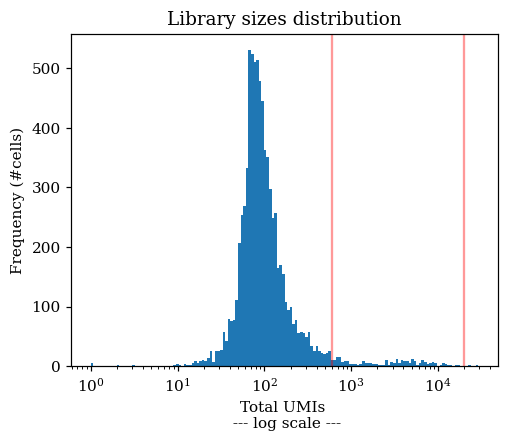

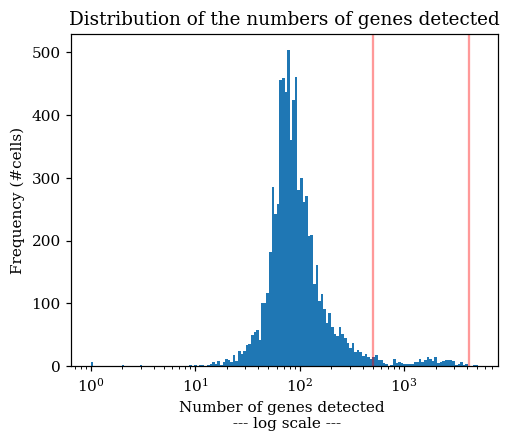

max_corr already annotated. Set ow = True if you want to overwrite.


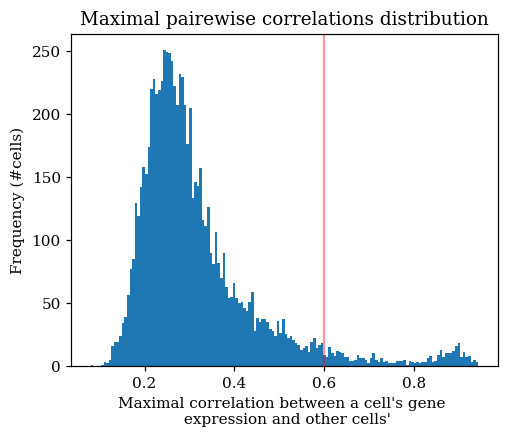

mt_frac already annotated. Set ow = True if you want to overwrite.


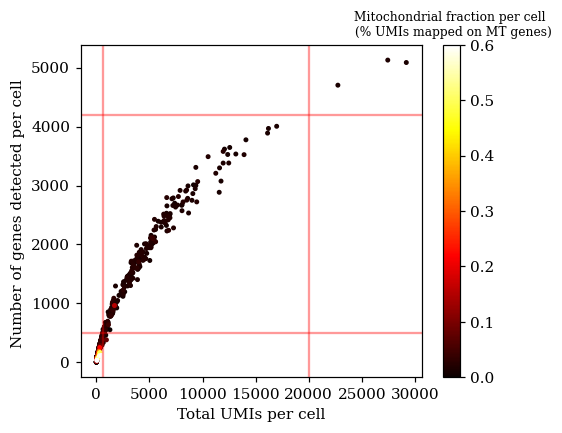

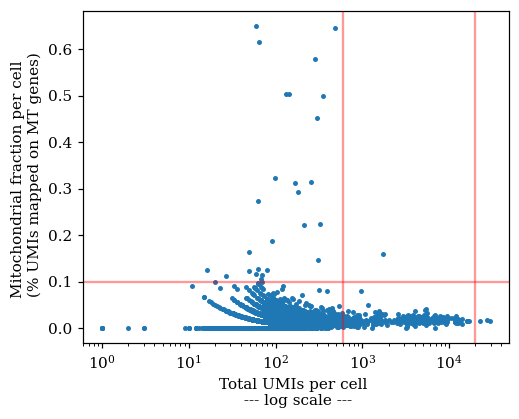

In [37]:
sc.plot_qc(n_counts_max=20000, n_counts_min = 600, n_genes_max=4200, n_genes_min = 500, mt_max = 0.1, max_corr_thr = 0.6, n_bins = 150)
sc.save()

Dataset already log-normalized. To overwrite, set ow = True.
Already performed pca. To overwrite, set ow = True.
Already performed umap. To overwrite, set ow = True.


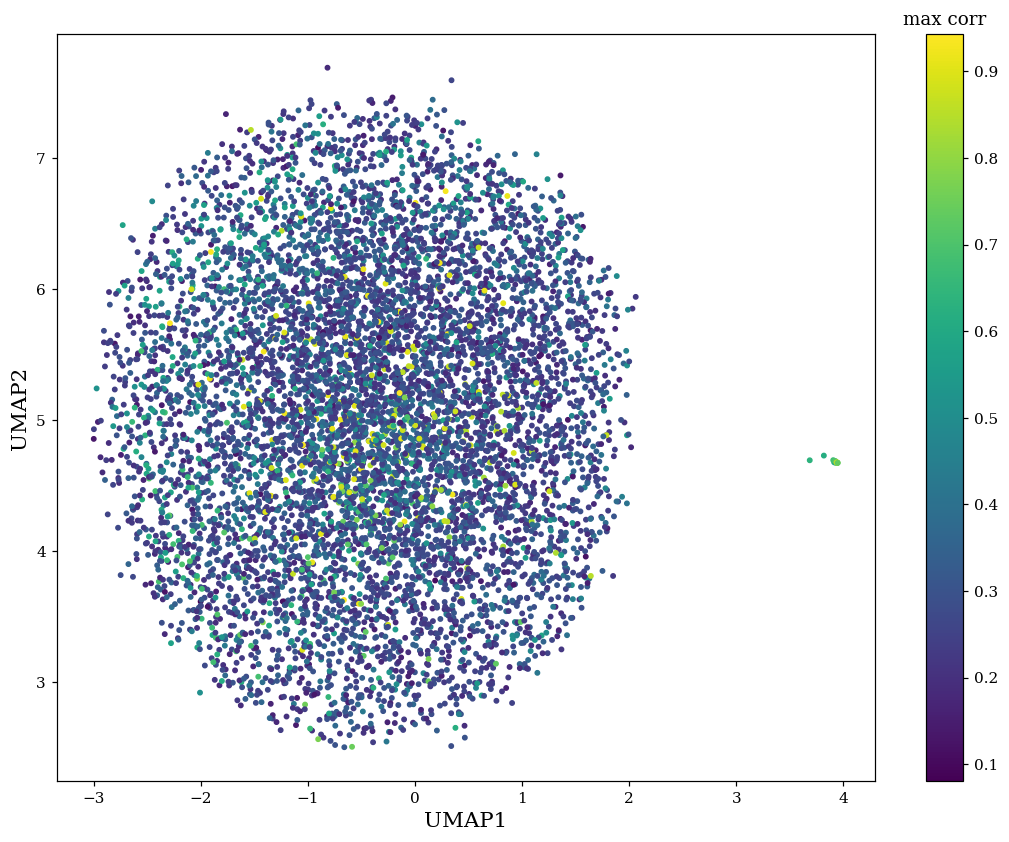

In [12]:
# sc.reload()
sc.lib_size_normalization(plot = False)
sc.dim_reduc(method="pca", color_by = "total_UMIs", plot=False)
sc.dim_reduc(method = "umap", layer="pca", color_by = "max_corr", markersize=8)

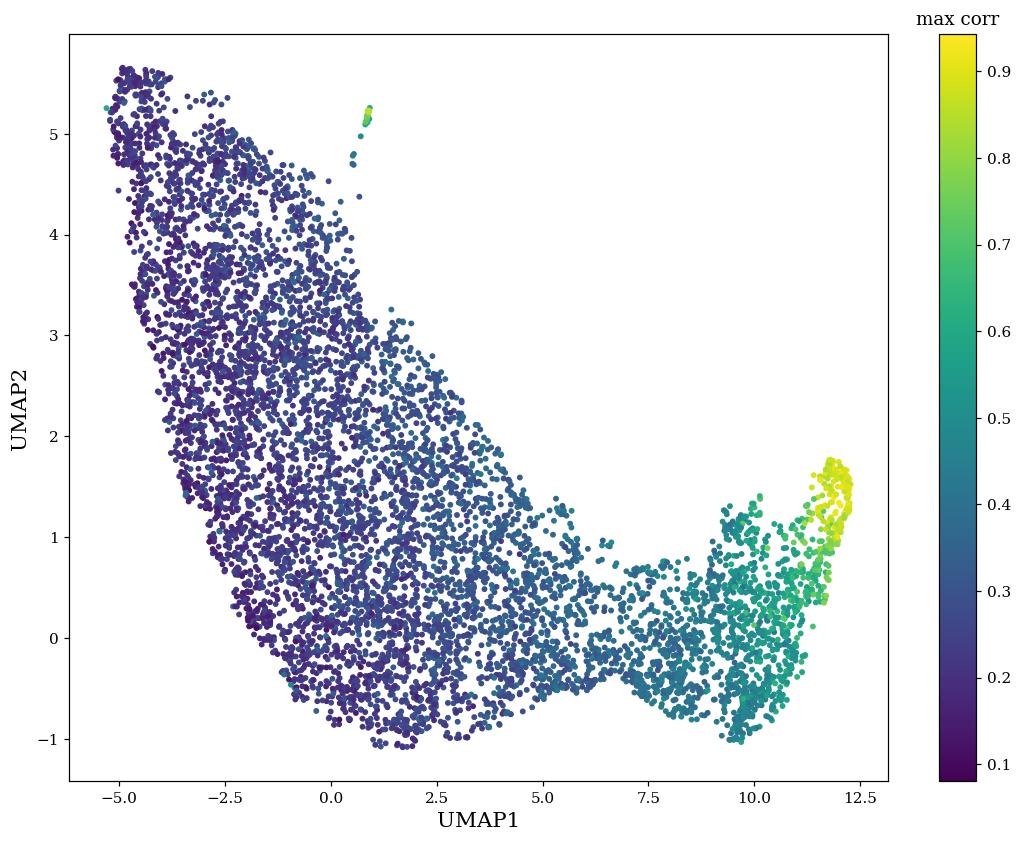

In [38]:
sc.dim_reduc(method = "umap", layer="scvi", color_by = "max_corr", markersize=8, ow = True)

In [39]:
km = KMeans(2).fit(sc.scvi)

In [40]:
sc.annotate_samples(samples_annot_name="cluster", samples_annot= km.labels_.astype(str), ow = True)

Annotating cluster...


Already performed umap. To overwrite, set ow = True.


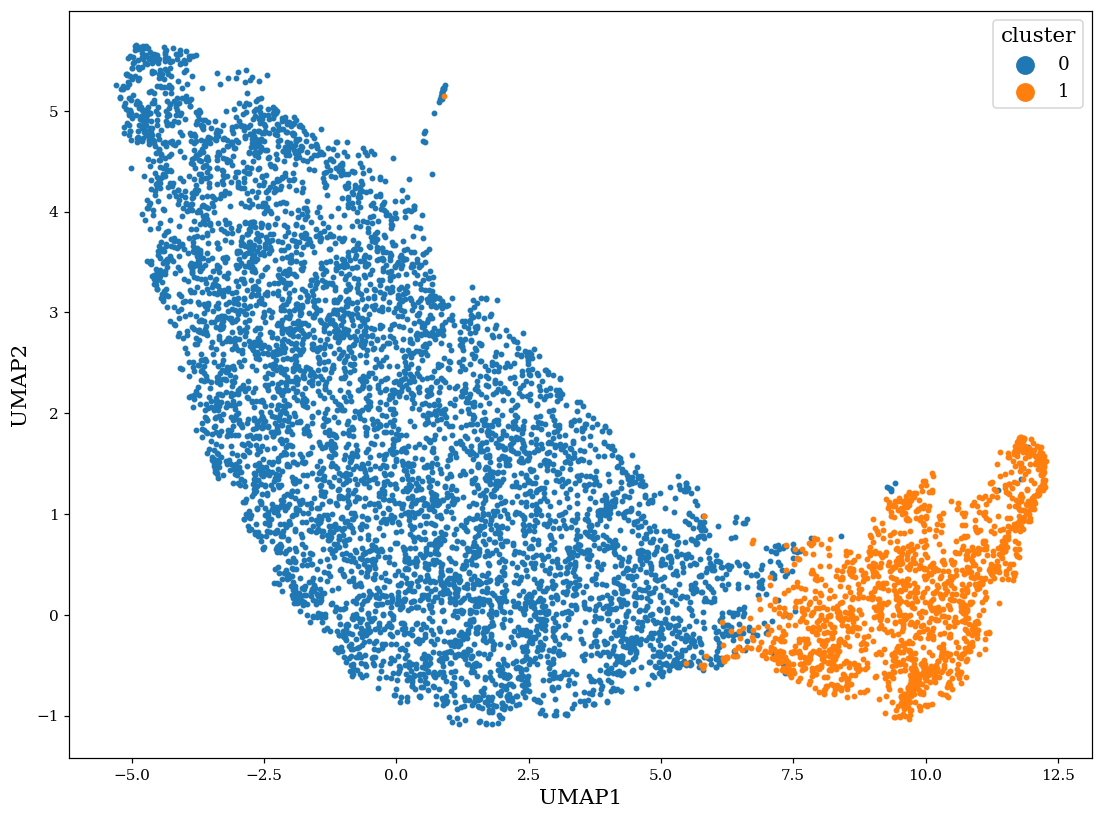

In [41]:
sc.dim_reduc(method = "umap", layer="scvi", color_by = "cluster", markersize=8, markerscale=4)

In [42]:
sc.mtx.shape

(7925, 20305)

In [43]:
sc.update_samples(km.labels_.astype(bool))

In [44]:
sc.mtx.shape

(1556, 20305)

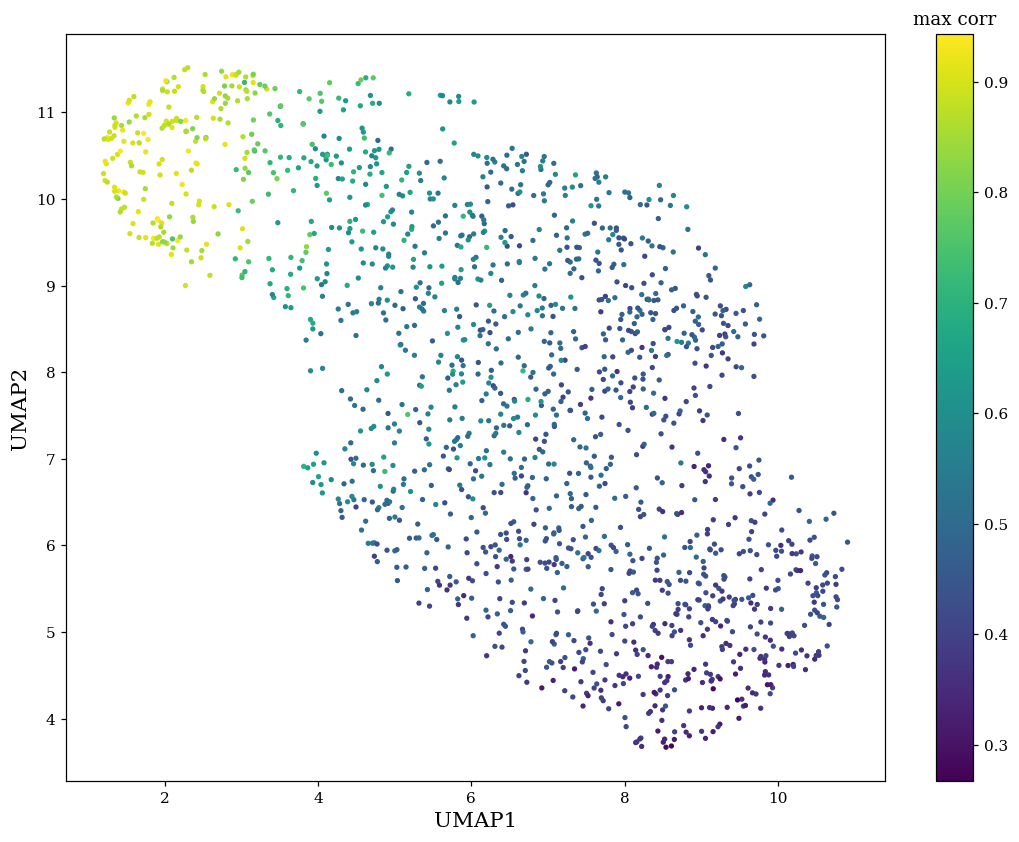

In [47]:
sc.dim_reduc(method = "umap", layer="scvi", color_by = "max_corr", markersize=6, min_dist = 0.2, ow = True)

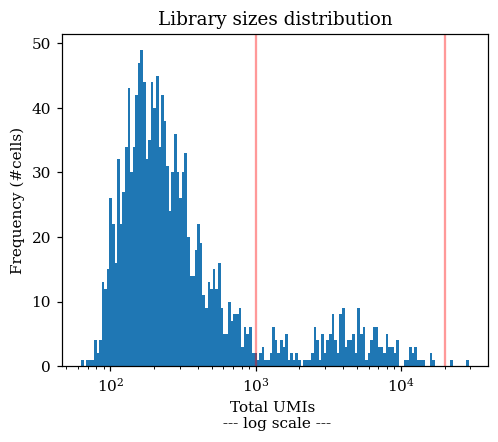

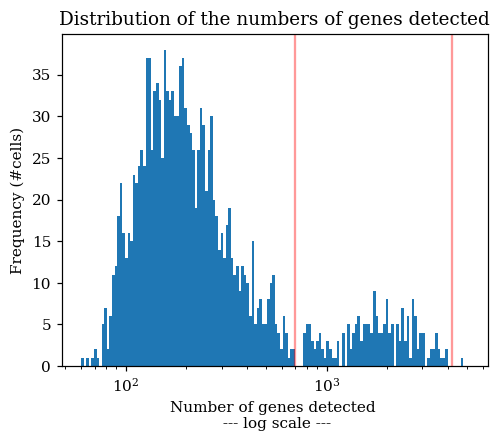

max_corr already annotated. Set ow = True if you want to overwrite.


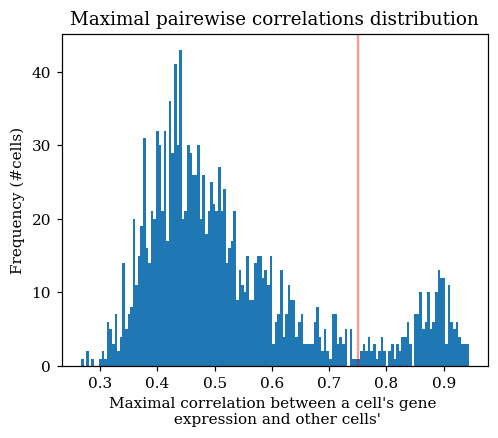

mt_frac already annotated. Set ow = True if you want to overwrite.


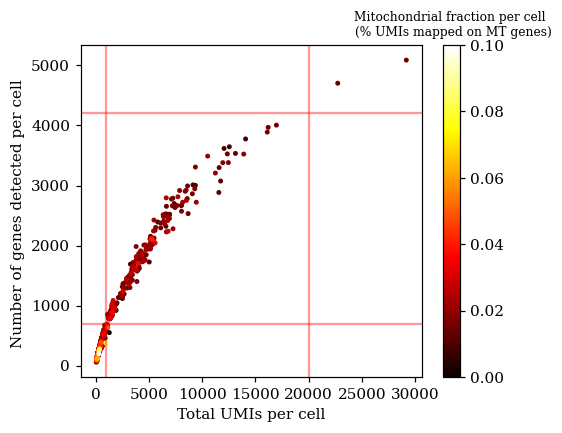

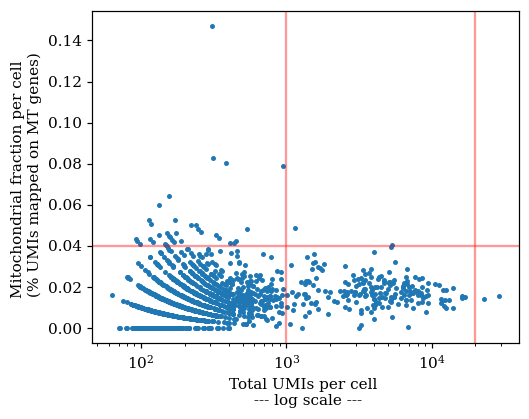

In [51]:
sc.plot_qc(n_counts_max=20000, n_counts_min = 1000, n_genes_max=4200, n_genes_min = 700, mt_max = 0.04, max_corr_thr = 0.75, n_bins = 150)

In [52]:
sc.filter_cells(n_counts_max=20000, n_counts_min = 1000, n_genes_max=4200, n_genes_min = 700, mt_max = 0.04, max_corr_thr = 0.75);
sc_s = sc.copy()
sc_s.save()

In [53]:
sc_s.mtx.shape

(184, 20305)

__Filtering cells__

In [22]:
sc.reload()
sc.filter_cells(n_counts_max=20000, n_counts_min = 600, n_genes_max=4200, n_genes_min = 500, mt_max = 0.1, max_corr_thr = 0.6);
sc_ns = sc.copy()
sc_ns.save()

In [17]:
sc_ns.mtx.shape

(254, 20305)

__QC after filtering__

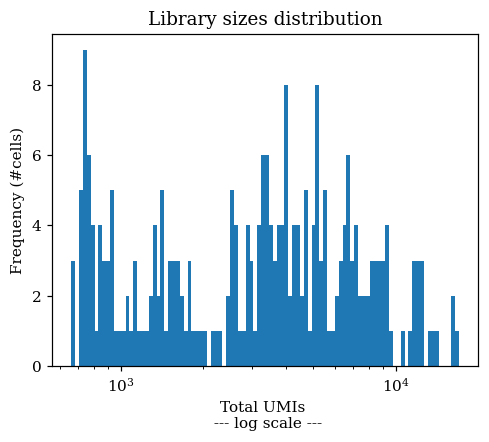

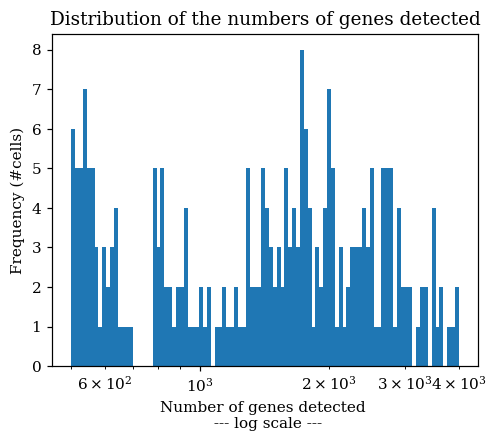

max_corr already annotated. Set ow = True if you want to overwrite.


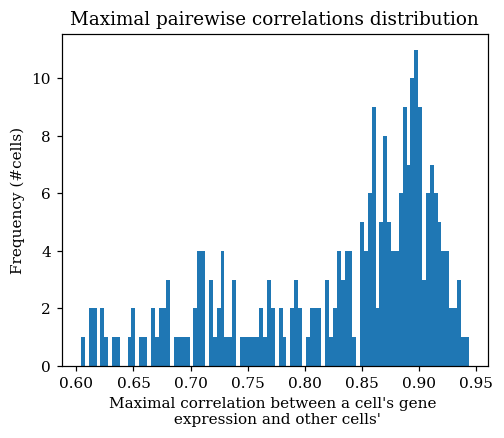

mt_frac already annotated. Set ow = True if you want to overwrite.


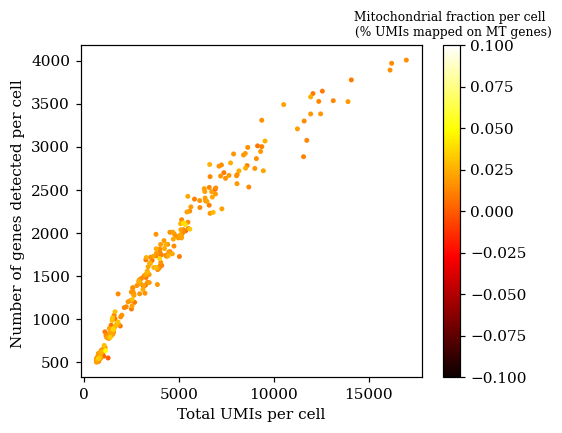

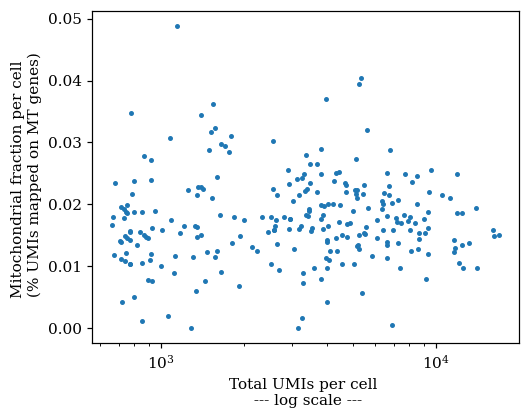

In [23]:
sc_ns.plot_qc(show_cutoffs=False)

Already performed pca. To overwrite, set ow = True.
Already performed umap. To overwrite, set ow = True.


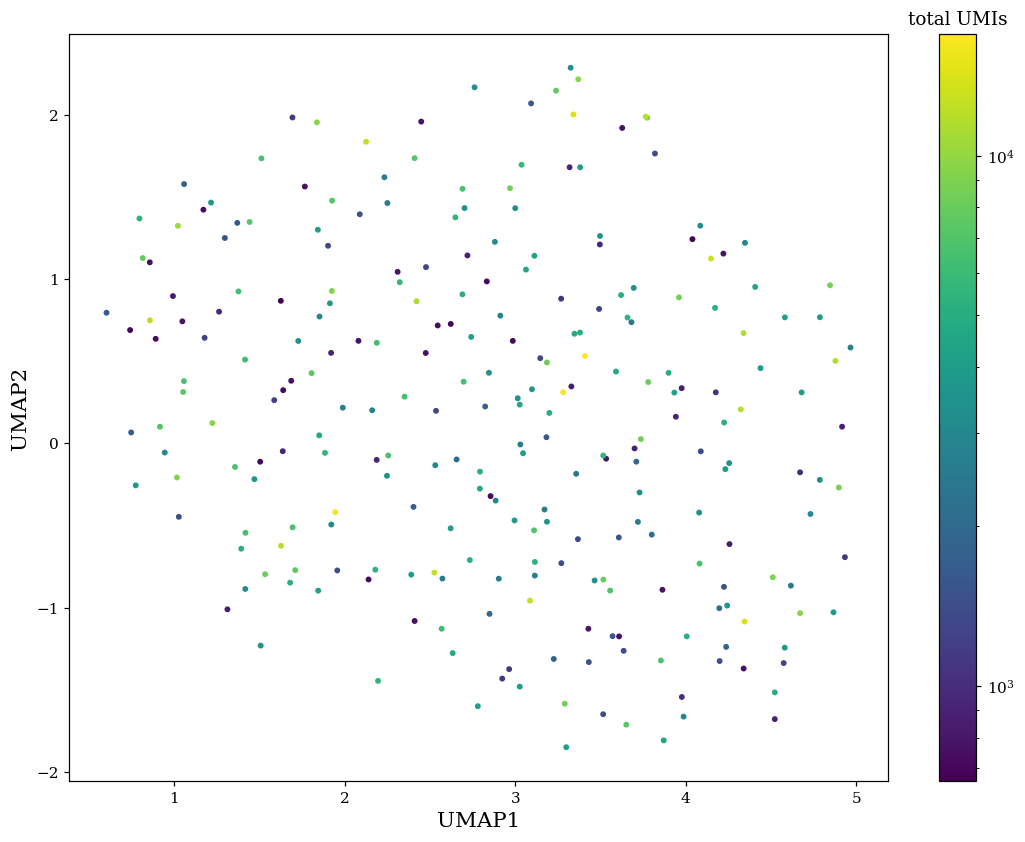

In [22]:
sc_ns.dim_reduc(method="pca", color_by = "total_UMIs", plot=False)
sc_ns.dim_reduc(method = "umap", layer="pca", color_by = "total_UMIs", color_log_scale=True, markersize=8)

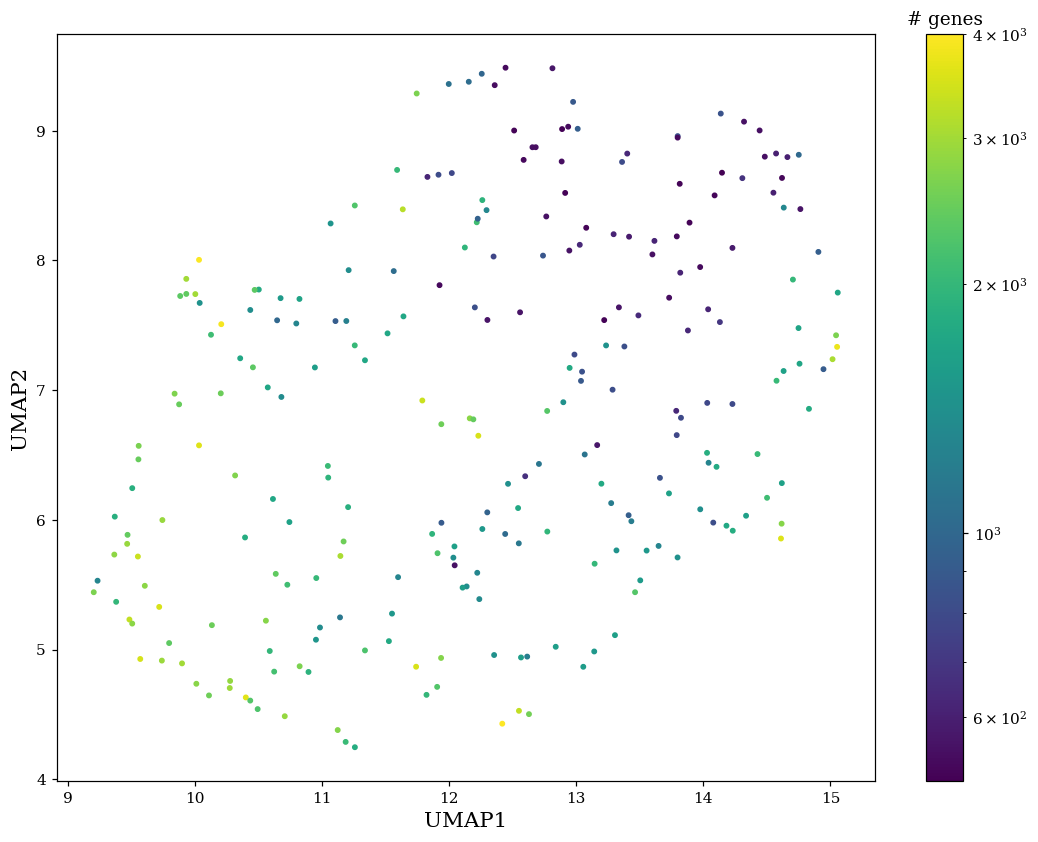

In [26]:
sc.dim_reduc(method = "umap", layer="scvi", color_by = "#_genes", color_log_scale=True, markersize=8, min_dist = 0.1, ow = True)

In [42]:
sc.mtx.shape

(7925, 20305)

### Stringent filtering

In [436]:
sc.reload()

__QC__

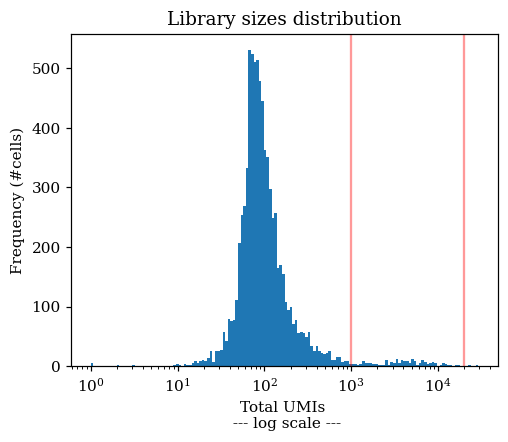

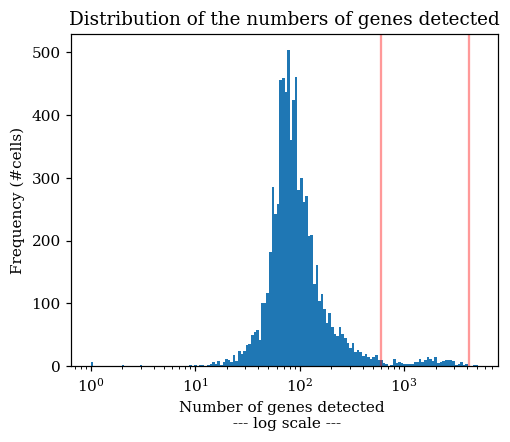

max_corr already annotated. Set ow = True if you want to overwrite.


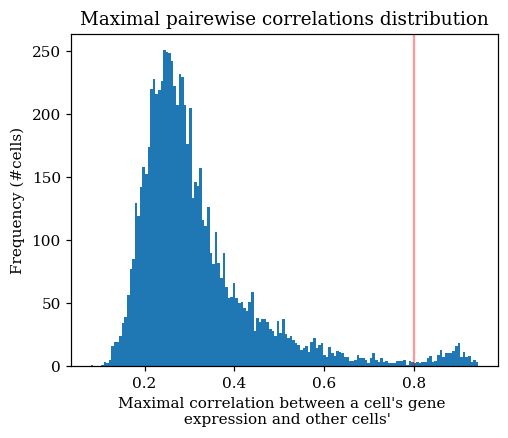

mt_frac already annotated. Set ow = True if you want to overwrite.


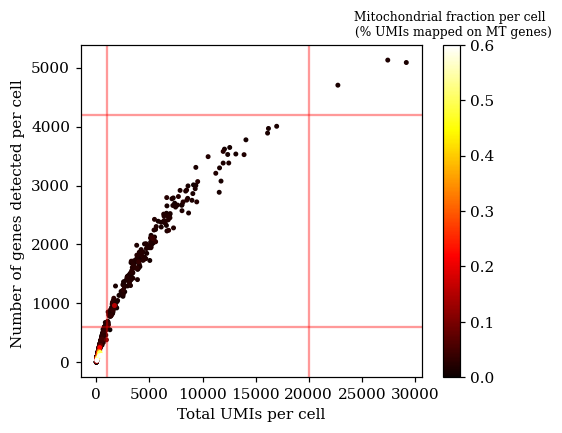

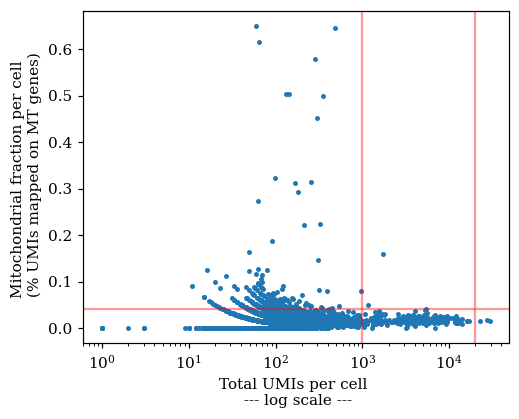

In [437]:
sc.plot_qc(n_counts_max=20000, n_counts_min = 1000, n_genes_max=4200, n_genes_min = 600, mt_max = 0.04, max_corr_thr = 0.8, n_bins = 150)

__Filtering cells__

In [438]:
sc.filter_cells(n_counts_max=20000, n_counts_min = 1000, n_genes_max=4200, n_genes_min = 600, mt_max = 0.04, max_corr_thr = 0.8);
sc_s = sc.copy()
sc_s.save()

In [439]:
sc_s.mtx.shape

(175, 20305)

__QC after filtering__

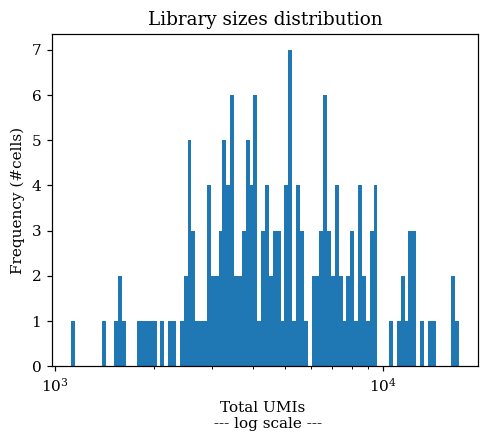

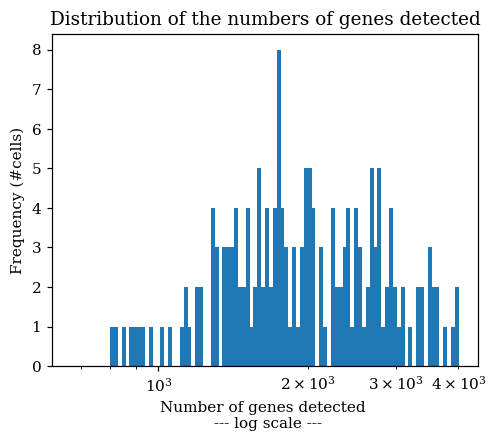

max_corr already annotated. Set ow = True if you want to overwrite.


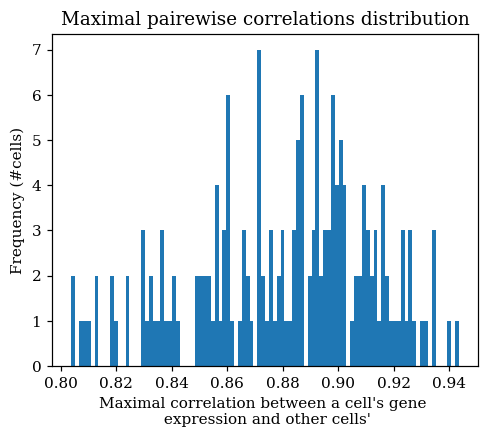

mt_frac already annotated. Set ow = True if you want to overwrite.


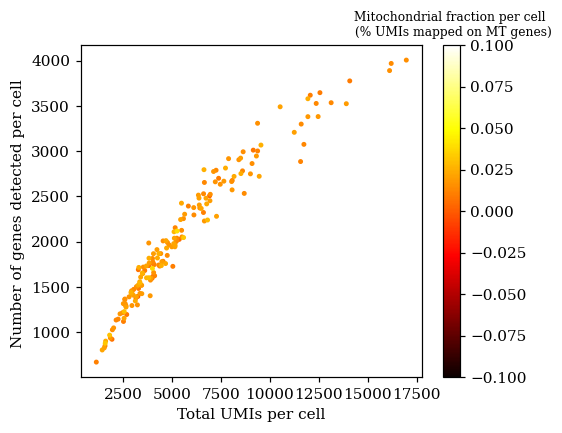

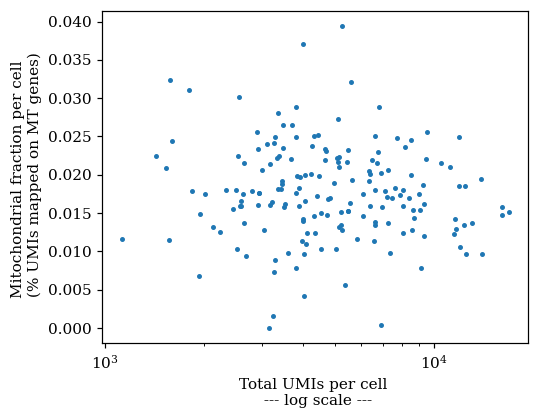

In [440]:
sc_s.plot_qc(show_cutoffs=False)

### Compare stringent & non stringent filtring

In [54]:
sc_ns.reload()
sc_ns.annotate_genes(genes_annot_name="external_gene_name")
sc_ns.annotate_samples(samples_annot_name="qc", samples_annot = np.array(["stringent" if b in sc_s.barcodes else "non-stringent" for b in sc_ns.barcodes], dtype = str), ow = True)
sc_ns.save()

NameError: name 'sc_ns' is not defined

In [419]:
# rep = 30
# sc_ns.reload()
# b = np.repeat(np.arange(0,rep).reshape(1, -1), len(sc_ns.mtx)//(rep-2), axis = 0).ravel()
# b = b[:len(sc_ns.mtx)].astype(str)
# np.random.shuffle(b)
# sc_ns.annotate_samples(samples_annot_name="batch", samples_annot=b)
# ps = sc_ns.pseudobulk(group_by_annot_name = ["qc", "batch"])

# ps.annotate_genes(genes_annot_name = "external_gene_name")
# ps.downsample(libs = 3000)

# ps.save()

# ps.lib_size_normalization(1e3)

# ps.ttest(samples_annot_name="qc", samples_annot_ref="stringent", samples_annot_test="non-stringent", top = 30, qval_cutoff = 0.05)

Annotating batch...
Annotating qc...
Annotating batch...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


Annotating batch...


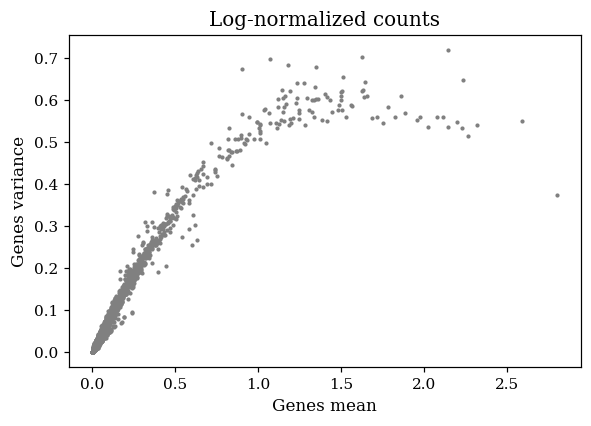

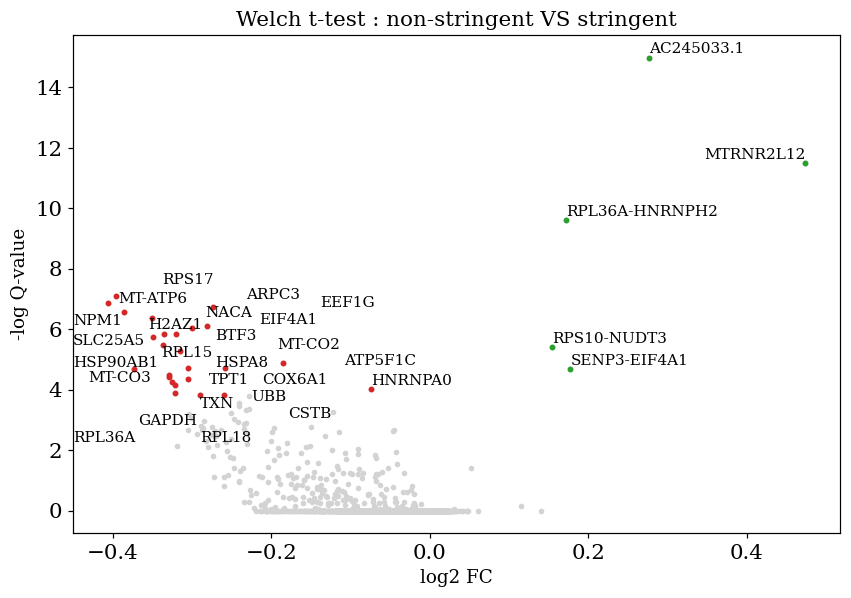

(array([ 0.27711314,  0.4740001 ,  0.17196023, ..., -0.00222889,
         0.00590127,  0.        ], dtype=float32),
 array([5.11740756e-20, 1.55274510e-16, 1.18295967e-14, ...,
        7.39200348e-01, 5.03251707e-01, 1.00000000e+00]),
 array([1.03908961e-15, 3.15284893e-12, 2.40199960e-10, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

In [442]:
sc_ns.reload()
b = np.repeat(np.arange(0,rep).reshape(1, -1), len(sc_ns.mtx)//(rep-2), axis = 0).ravel()
b = b[:len(sc_ns.mtx)].astype(str)
sc_ns.annotate_samples(samples_annot_name="batch", samples_annot=b)

# sc_ns.downsample(libs = int(min(sc_ns.mtx.sum(1))))
sc_ns.lib_size_normalization()

sc_ns.ttest(samples_annot_name="qc", samples_annot_ref="stringent", samples_annot_test="non-stringent", top = 30, qval_cutoff = 0.05)

### Saving filtered count matrix

In [443]:
sc_s.save_files(pp="filtered")